In [1]:
! source ./env/bin/activate

In [2]:
### IMPORTING ALL LIBRARIES

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

/var/folders/dq/zq2spyr52zjfyw178gk_b_900000gn/T/ipykernel_32370/1285346317.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot:>

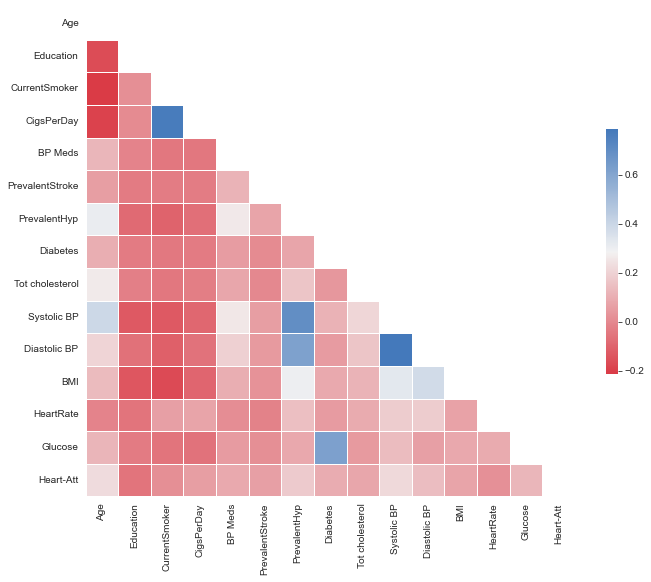

In [3]:
### Feature Importance

df = pd.read_csv("US_Heart_Patients.csv")

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True) 
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [4]:
### Drop columns with less correlation

temp = df.copy()

X = temp.drop(['Heart-Att', 'Age', 'PrevalentHyp', 'Systolic BP'], axis = 1)
y = df['Heart-Att'].values

In [5]:
## Create Pipelines

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False)) # Here Sparse is working
])

In [6]:
numerical_features = ['CigsPerDay', 'Tot cholesterol', 'Diastolic BP', 'BMI', 'HeartRate', 'Glucose']
categorical_features = ['Gender']

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [7]:
### Split as train test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=34)

In [8]:
### Defining the model

clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0, min_samples_leaf = 7, min_samples_split = 10)
etc = ExtraTreesClassifier(random_state=0, n_estimators=100, max_depth=3)

In [9]:
### Create and fit pipelines

RF_Pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', clf)
])

ET_Pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', etc)
])


clf_trained = RF_Pipeline.fit(X_train, y_train)
etc_trained = ET_Pipeline.fit(X_train, y_train)

In [10]:
### Prediction and Accuracy

preds_1 = RF_Pipeline.predict(X_valid)
preds_2 = ET_Pipeline.predict(X_valid)

acc_1 = accuracy_score(y_valid, preds_1)
acc_2 = accuracy_score(y_valid, preds_2)

f1_1 = f1_score(y_valid, preds_1, average = 'weighted')
f1_2 = f1_score(y_valid, preds_2, average = 'weighted')

print("\n")
print(acc_1, acc_2)
print("\n")
print(f1_1, f1_2)



0.8624213836477987 0.8616352201257862


0.7994951728288627 0.7975947645758966


In [11]:
### Pipeline Scores

print(RF_Pipeline.score(X_valid, y_valid), end = " ")
print(ET_Pipeline.score(X_valid, y_valid))

0.8624213836477987 0.8616352201257862


In [12]:
### Confusion Matrix

confusion_matrix(y_valid, preds_1)

array([[1096,    0],
       [ 175,    1]])

### Hyperparameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

param_grid = {
    'model__bootstrap': [True],
    'model__max_depth': [3, 5, 7],
    'model__max_features': [5, 7],
    'model__min_samples_leaf': [3, 4, 5, 7],
    'model__min_samples_split': [8, 10, 12],
    'model__n_estimators': [100, 200, 300, 500, 1000]
}

'''
Bootstrap means that instead of training on all the observations, each tree of RF is trained on a subset of the observations. The chosen subset is called the bag, and the remaining are called Out of Bag samples. Multiple trees are trained on different bags, and later the results from all the trees are aggregated.
max_depth: The number of splits that each decision tree is allowed to make.
max_features: The number of columns that are shown to each decision tree. 
n_estimators = Number of Trees
min_samples_leaf parameter checks before the node is generated, that is, if the possible split results in a child with fewer samples, the split will be avoided
min_samples_split parameter will evaluate the number of samples in the node, and if the number is less than the minimum the split will be avoided and the node will be a leaf.


max_samples: If bootstrap is set to true, the maximum number of rows that can be passed to each decision tree is controlled by the max_samples parameter.

'''

# Underfitting and Overfitting the model
# Understand how the model works (Bagging and Boosting)

# What are these parameters and functions
# Umderstand random forest
search = GridSearchCV(RF_Pipeline, param_grid, cv = 3, n_jobs = -1, verbose = 2, return_train_score = True)
_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))
print('Best Params:', search.best_params_)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=200; total time=   1.2s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=300; total time=   1.7s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=500; total time=   2.3s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=10, model__n_estimators=100; total time=   0.5s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=10, model__n_estimators=100; total time=   0.5s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_f

[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=100; total time=   0.6s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=200; total time=   1.2s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=500; total time=   2.5s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=1000; total time=   4.5s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=10, model__n_estimators=300; total time=   1.3s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=1

[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=100; total time=   0.6s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=200; total time=   1.2s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=300; total time=   1.6s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=1000; total time=   4.5s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=10, model__n_estimators=200; total time=   0.9s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=1

[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=100; total time=   0.6s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=300; total time=   1.8s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=500; total time=   2.4s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=1000; total time=   4.5s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=10, model__n_estimators=500; total time=   2.2s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=1

[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=10, model__n_estimators=1000; total time=   5.1s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=12, model__n_estimators=500; total time=   2.6s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=12, model__n_estimators=1000; total time=   5.5s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=300; total time=   1.7s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=1000; total time=   6.8s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_spl

[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=100; total time=   0.6s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=100; total time=   0.6s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=200; total time=   1.1s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=200; total time=   1.3s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=300; total time=   1.7s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_split=8, 

[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=12, model__n_estimators=200; total time=   1.1s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=12, model__n_estimators=200; total time=   1.0s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=12, model__n_estimators=300; total time=   1.5s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=12, model__n_estimators=500; total time=   2.6s
[CV] END model__bootstrap=True, model__max_depth=3, model__max_features=7, model__min_samples_leaf=7, model__min_samples_split=12, model__n_estimators=1000; total time=   5.2s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=3, model__min_samples_spl

[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   1.1s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=300; total time=   1.7s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=500; total time=   2.9s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000; total time=   5.5s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=4, model__min_samples_split=12, model__n_estimators=500; total time=   2.8s
[CV] END model__bootstrap=True, model__max_depth=5, model__max_features=5, model__min_samples_leaf=4, model__min_samples_spl

Best score: 0.8440022060851181
Best Params: {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 12, 'model__n_estimators': 500}


Best score: 0.8440022060851181
Best Params: {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 12, 'model__n_estimators': 500}

In [21]:
clf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0, min_samples_leaf = 4, min_samples_split = 12, max_features = 5, bootstrap = True)


RF_Pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', clf)
])

clf_trained = RF_Pipeline.fit(X_train, y_train)
preds_1 = clf_trained.predict(X_valid)

acc_1 = accuracy_score(y_valid, preds_1)

acc_1

0.8592767295597484

In [37]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


# Difference between regressor and classifier : Classification is the task of predicting a discrete class label. Regression is the task of predicting a continuous quantity
# Why accuracy is not increasing

lr = LogisticRegression()
clf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0, min_samples_leaf = 4, min_samples_split = 12, max_features = 5, bootstrap = True)
ada = AdaBoostClassifier(n_estimators=500, random_state=0)

reg = [('clf',clf), ('ada', ada)]
stack_model = StackingClassifier(estimators = reg, final_estimator = lr)

RF_Pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', stack_model)
])

clf_trained = RF_Pipeline.fit(X_train, y_train)
preds_1 = clf_trained.predict(X_valid).round()

acc_1 = accuracy_score(y_valid, preds_1)

acc_1

0.860062893081761

In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


# Difference between regressor and classifier : Classification is the task of predicting a discrete class label. Regression is the task of predicting a continuous quantity
# Why accuracy is not increasing

lr = LogisticRegression()
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0, min_samples_leaf = 7, min_samples_split = 10)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)

reg = [('clf',clf), ('ada', ada)]
stack_model = StackingClassifier(estimators = reg, final_estimator = lr)

RF_Pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', stack_model)
])

clf_trained = RF_Pipeline.fit(X_train, y_train)
preds_1 = clf_trained.predict(X_valid).round()

acc_1 = accuracy_score(y_valid, preds_1)

acc_1


# Analysis is vast and it changes according to the data
# Time series analysis is very huge
# Explore time series data on your own (Importance of it, trends, graphs) : Important in interviews, it is a different domain
# How to sample the data (Per second data into hourly data)
# ROC curve (Metrics)

# LinkedIn connect with sir : 
    # Send sir the notes and project file
    
# be consistent and dont stop working and learning
# Less is more, know less but know it well

# Try connecting with people on LinkedIn and getting recommendations from them and then apply. Show him that you have done all these project in one message
# look at programs or getting without it. Which comapnies like space related startups or which domain like finance
# Stay connected with sir


0.8624213836477987